## Task 1: Preparation and Training - Build upon the code discussed in class. Do not use pre-built solutions from the internet.
1) Read and understand the Word2Vec1 and GloVe2 papers.
2) Modify the Word2Vec (with & without negative sampling) and GloVe from the lab lecture (3 points)
- Train using a real-world corpus (suggest to categories news from nltk datset). Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation.
- Create a function that allows dynamic modification of the window size during training. Use a window size of 2 as default.

In [1]:
import time, re, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time, re, os, math
from collections import Counter
from itertools import combinations_with_replacement

In [2]:
print("numpy:", np.__version__)
print("torch:", torch.__version__)

numpy: 2.4.1
torch: 2.9.1+cpu


### Load data (nltk datset)
We use the Brown Corpus (news category) provided by NLTK.
Source: NLTK corpus module (Brown Corpus).


In [3]:
import nltk
nltk.download("brown")

from nltk.corpus import brown

def load_news_corpus(max_sentences=20000):
    sents = brown.sents(categories="news")[:max_sentences]
    corpus = []
    for sent in sents:
        toks = [w.lower() for w in sent]
        toks = [w for w in toks if re.fullmatch(r"[a-z]+", w)]
        if len(toks) >= 2:
            corpus.append(toks)
    return corpus

corpus = load_news_corpus(max_sentences=20000)
print("num sentences:", len(corpus))
print("example:", corpus[0][:20])

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


num sentences: 4555
example: ['the', 'fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of', 'recent', 'primary', 'election', 'produced', 'no', 'evidence', 'that', 'any', 'irregularities', 'took']


In [4]:
# Build vocabulary from corpus and create word-index mappings
def build_vocab(corpus, min_count=5, max_vocab=30000):
    counts = Counter(w for sent in corpus for w in sent)
    items = [(w,c) for w,c in counts.items() if c >= min_count]
    items.sort(key=lambda x: x[1], reverse=True)
    items = items[:max_vocab]

    vocabs = [w for w,_ in items]
    vocabs.append("<UNK>")

    word2index = {w:i for i,w in enumerate(vocabs)}
    index2word = {i:w for w,i in word2index.items()}
    return vocabs, word2index, index2word, counts

vocabs, word2index, index2word, raw_counts = build_vocab(corpus, min_count=5, max_vocab=30000)
voc_size = len(vocabs)
print("vocab size:", voc_size)
print("top10:", vocabs[:10])

vocab size: 2373
top10: ['the', 'of', 'and', 'to', 'a', 'in', 'for', 'that', 'is', 'was']


In [6]:
# Context window scheduling strategy for curriculum learning
def window_schedule(step, default=2):
    if step < 3000:
        return default
    elif step < 6000:
        return default + 1
    else:
        return default + 2

In [7]:
# Generate skip-gram (center, context) word pairs from the corpus
def make_skipgrams(corpus, word2index, window_size=2):
    unk = word2index["<UNK>"]
    pairs = []

    for sent in corpus:
        sent_ids = [word2index.get(w, unk) for w in sent]
        for i in range(len(sent_ids)):
            center = sent_ids[i]
            left = max(0, i - window_size)
            right = min(len(sent_ids), i + window_size + 1)
            for j in range(left, right):
                if j == i:
                    continue
                outside = sent_ids[j]
                pairs.append([center, outside])

    return np.array(pairs, dtype=np.int64)

# Randomly sample skip-gram pairs for mini-batch training
def random_batch_from_corpus(corpus, word2index, batch_size, window_size=2):
    unk = word2index["<UNK>"]
    centers = np.empty((batch_size,), dtype=np.int64)
    outsides = np.empty((batch_size,), dtype=np.int64)

    b = 0
    while b < batch_size:
        sent = corpus[np.random.randint(0, len(corpus))]
        if len(sent) < 2:
            continue

        ids = [word2index.get(w, unk) for w in sent]

        i = np.random.randint(0, len(ids))
        left = max(0, i - window_size)
        right = min(len(ids), i + window_size + 1)

        ctx = [j for j in range(left, right) if j != i]
        if not ctx:
            continue

        j = np.random.choice(ctx)

        centers[b] = ids[i]
        outsides[b] = ids[j]
        b += 1

    return centers, outsides


window_size = 2 
pairs = make_skipgrams(corpus, word2index, window_size=window_size)
print("num pairs:", len(pairs))
print("sample:", pairs[:5])

num pairs: 306722
sample: [[  0 719]
 [  0 124]
 [719   0]
 [719 124]
 [719 508]]


### Task 1 - Word2Vec (Skipgram)

In [8]:
# Skip-gram model with full softmax
class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, outside, all_vocabs):
        v_c = self.embedding_center(center)                 
        u_o = self.embedding_outside(outside)              
        U_all = self.embedding_outside(all_vocabs)       

        top = torch.exp(u_o.bmm(v_c.transpose(1,2)).squeeze(2))  

        scores_all = U_all.bmm(v_c.transpose(1,2)).squeeze(2)     
        bottom = torch.sum(torch.exp(scores_all), dim=1, keepdim=True) 

        loss = -torch.mean(torch.log(top / (bottom + 1e-12) + 1e-12))
        return loss

In [ ]:
# Training
batch_size = 256
emb_size = 100
lr = 0.001
num_steps = 10000

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_1 = Skipgram(voc_size, emb_size).to(device)
optimizer = optim.Adam(model_1.parameters(), lr=lr)

loss_history_1 = []
start = time.time()

for step in range(num_steps):
    ws = window_schedule(step, default=2)

    # sample a random mini-batch of (center, outside) pairs
    x, y = random_batch_from_corpus(corpus, word2index, batch_size, window_size=ws)

    center = torch.LongTensor(x).unsqueeze(1).to(device)   # (B, 1)
    outside = torch.LongTensor(y).unsqueeze(1).to(device)  # (B, 1)

    # build vocab indices for full softmax denominator (match current batch size + device)
    all_vocabs = torch.arange(voc_size, device=device).unsqueeze(0).expand(center.size(0), voc_size)

    loss = model_1(center, outside, all_vocabs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history_1.append(loss.item())

    if (step + 1) % 200 == 0:
        print(f"Step {step+1}/{num_steps} | window={ws} | loss={loss.item():.4f}")

final_ws = ws
train_time_1 = time.time() - start
print("Training time (sec):", train_time_1)
print("Final window size:", final_ws)

Step 200/10000 | window=2 | loss=21.6592
Step 400/10000 | window=2 | loss=18.8160
Step 600/10000 | window=2 | loss=17.7281
Step 800/10000 | window=2 | loss=16.3603
Step 1000/10000 | window=2 | loss=16.4624
Step 1200/10000 | window=2 | loss=14.0787
Step 1400/10000 | window=2 | loss=13.5221
Step 1600/10000 | window=2 | loss=13.0288
Step 1800/10000 | window=2 | loss=12.7485
Step 2000/10000 | window=2 | loss=11.9540
Step 2200/10000 | window=2 | loss=11.0540
Step 2400/10000 | window=2 | loss=10.8933
Step 2600/10000 | window=2 | loss=11.7317
Step 2800/10000 | window=2 | loss=11.2261
Step 3000/10000 | window=2 | loss=10.1825
Step 3200/10000 | window=3 | loss=9.8944
Step 3400/10000 | window=3 | loss=9.5715
Step 3600/10000 | window=3 | loss=10.8754
Step 3800/10000 | window=3 | loss=9.7440
Step 4000/10000 | window=3 | loss=9.0184
Step 4200/10000 | window=3 | loss=9.8944
Step 4400/10000 | window=3 | loss=9.0309
Step 4600/10000 | window=3 | loss=8.4946
Step 4800/10000 | window=3 | loss=8.7005
Step

PCA variance ratio: [0.06104474 0.05458977]


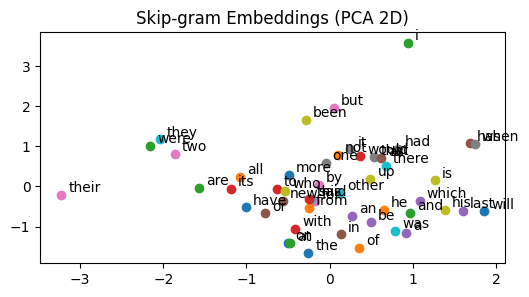

In [10]:
# Extract Skip-gram word embeddings and visualize them using PCA
from sklearn.decomposition import PCA
def get_skipgram_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model_1.embedding_center(idx_t)
    u = model_1.embedding_outside(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

words_to_plot = vocabs[:50]
embs = np.array([get_skipgram_embed(w) for w in words_to_plot])

pca = PCA(n_components=2)
embs_2d = pca.fit_transform(embs)

print("PCA variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("Skip-gram Embeddings (PCA 2D)")
plt.show()

### Task 1 - Word2Vec (Negative Sampling)

In [11]:
# Prepare word sampling probabilities for negative sampling in Skip-gram
raw_counts = Counter([w for sent in corpus for w in sent])
vocab_counts = np.array([raw_counts.get(w, 0) for w in vocabs], dtype=np.int64)

def neg_sampling_prob(vocab_counts, power=0.75):
    p = vocab_counts.astype(np.float64) ** power
    p = p / (p.sum() + 1e-12)
    return p

neg_prob = neg_sampling_prob(vocab_counts, power=0.75)
neg_prob[:10], neg_prob.sum()

(array([0.03156336, 0.01728423, 0.01412535, 0.01392131, 0.01385308,
        0.01331297, 0.00767369, 0.00682618, 0.00622429, 0.00612211]),
 np.float64(1.0))

In [14]:
# Model
class SkipgramNEG(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, pos_outside, neg_outsides):

        v_c = self.embedding_center(center).squeeze(1)        # (B,E)
        u_o = self.embedding_outside(pos_outside).squeeze(1)  # (B,E)
        u_n = self.embedding_outside(neg_outsides)            # (B,K,E)

        # dot products
        s_pos = torch.sum(v_c * u_o, dim=1)                   # (B,)
        s_neg = torch.einsum("be,bke->bk", v_c, u_n)          # (B,K)

        # sigmoid loss
        loss_pos = -torch.log(torch.sigmoid(s_pos) + 1e-12)             
        loss_neg = -torch.sum(torch.log(torch.sigmoid(-s_neg) + 1e-12), dim=1)

        loss = torch.mean(loss_pos + loss_neg)
        return loss

# Negative sampling
def sample_negatives(batch_size, K, neg_prob, avoid_pos=None, avoid_center=None, seed=None):
    rng = np.random.default_rng(seed)
    negs = rng.choice(len(neg_prob), size=(batch_size, K), replace=True, p=neg_prob).astype(np.int64)

    if avoid_pos is not None:
        avoid_pos = np.asarray(avoid_pos, dtype=np.int64)
    if avoid_center is not None:
        avoid_center = np.asarray(avoid_center, dtype=np.int64)

    if avoid_pos is not None or avoid_center is not None:
        for i in range(batch_size):
            for k in range(K):
                while True:
                    bad = False
                    if avoid_pos is not None and negs[i, k] == avoid_pos[i]:
                        bad = True
                    if avoid_center is not None and negs[i, k] == avoid_center[i]:
                        bad = True
                    if not bad:
                        break
                    negs[i, k] = rng.choice(len(neg_prob), p=neg_prob)

    return negs

In [15]:
# Training
batch_size = 256
emb_size = 100
lr = 0.002
num_steps = 10000
K = 10 # number of negative samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_2 = SkipgramNEG(voc_size, emb_size).to(device)
optimizer = optim.Adam(model_2.parameters(), lr=lr)

loss_history_2 = []
start = time.time()

for step in range(num_steps):
    ws = window_schedule(step, default=2)

    cx, oy = random_batch_from_corpus(corpus, word2index, batch_size, window_size=ws)

    # make center/pos as (B,) then unsqueeze(1) at forward call
    center = torch.LongTensor(cx).to(device)   # (B,)
    pos    = torch.LongTensor(oy).to(device)   # (B,)

    # sample negatives
    negs_np = sample_negatives(
        batch_size, K, neg_prob,
        avoid_pos=pos.detach().cpu().numpy(),
        avoid_center=center.detach().cpu().numpy())
    
    negs = torch.LongTensor(negs_np).to(device)  # (B,K)
    loss = model_2(center.unsqueeze(1), pos.unsqueeze(1), negs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history_2.append(loss.item())

    if (step + 1) % 200 == 0:
        print(f"Step {step+1:4d}/{num_steps} | window={ws} | Loss: {loss.item():.4f}")

final_ws = ws
train_time_2 = time.time() - start
print("Training time (sec):", train_time_2)
print("Final window size:", final_ws)

Step  200/10000 | window=2 | Loss: 31.4379
Step  400/10000 | window=2 | Loss: 27.3914
Step  600/10000 | window=2 | Loss: 21.3433
Step  800/10000 | window=2 | Loss: 18.7331
Step 1000/10000 | window=2 | Loss: 17.2217
Step 1200/10000 | window=2 | Loss: 15.4437
Step 1400/10000 | window=2 | Loss: 11.9803
Step 1600/10000 | window=2 | Loss: 9.9857
Step 1800/10000 | window=2 | Loss: 8.6297
Step 2000/10000 | window=2 | Loss: 8.9956
Step 2200/10000 | window=2 | Loss: 6.8325
Step 2400/10000 | window=2 | Loss: 6.3573
Step 2600/10000 | window=2 | Loss: 5.6642
Step 2800/10000 | window=2 | Loss: 5.9513
Step 3000/10000 | window=2 | Loss: 5.0159
Step 3200/10000 | window=3 | Loss: 4.7687
Step 3400/10000 | window=3 | Loss: 5.1374
Step 3600/10000 | window=3 | Loss: 4.7031
Step 3800/10000 | window=3 | Loss: 4.5079
Step 4000/10000 | window=3 | Loss: 4.2611
Step 4200/10000 | window=3 | Loss: 3.9954
Step 4400/10000 | window=3 | Loss: 3.5169
Step 4600/10000 | window=3 | Loss: 3.6155
Step 4800/10000 | window=3 

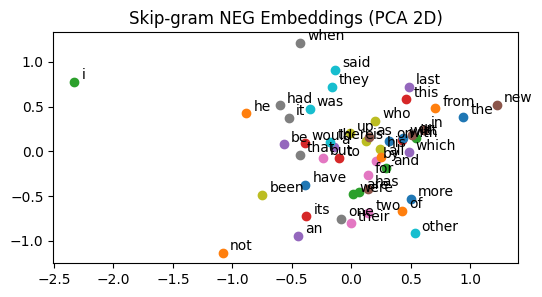

In [16]:
# Extract Skip-gram NEG word embeddings and visualize them using PCA
def get_neg_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model_2.embedding_center(idx_t)
    u = model_2.embedding_outside(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

words_to_plot = vocabs[:50]
embs = np.array([get_neg_embed(w) for w in words_to_plot])

pca = PCA(n_components=2)
embs_2d = pca.fit_transform(embs)

plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("Skip-gram NEG Embeddings (PCA 2D)")
plt.show()

### Task 1 - GloVE

In [17]:
# Build GloVe co-occurrence statistics and weighting function from skip-gram pairs
def build_glove_stats_from_pairs(pairs, x_max=100, alpha=0.75):
    X_ik_skipgrams = Counter(map(tuple, pairs))

    X_ik = {}
    weighting_dic = {}

    def weighting(i, j):
        x_ij = X_ik.get((i, j), 1.0)
        return (x_ij / x_max) ** alpha if x_ij < x_max else 1.0

    for (wi, wj), co in X_ik_skipgrams.items():
        X_ik[(wi, wj)] = float(co) + 1.0
        weighting_dic[(wi, wj)] = weighting(wi, wj)

    return X_ik, weighting_dic

In [18]:
def random_batch_glove(batch_size, pairs, X_ik, weighting_dic):
    rand_idx = np.random.choice(len(pairs), batch_size, replace=False)
    batch_pairs = pairs[rand_idx]                

    inputs = batch_pairs[:, 0:1].astype(np.int64) 
    labels = batch_pairs[:, 1:2].astype(np.int64) 

    coocs = np.empty((batch_size, 1), dtype=np.float32)
    weightings = np.empty((batch_size, 1), dtype=np.float32)

    for n, (i, j) in enumerate(batch_pairs):
        x_ij = X_ik.get((int(i), int(j)), 1.0)
        coocs[n, 0] = math.log(x_ij)

        w_ij = weighting_dic.get((int(i), int(j)), 1.0)
        weightings[n, 0] = w_ij

    return inputs, labels, coocs, weightings

In [19]:
# Model
class Glove(nn.Module):
    def __init__(self, voc_size, emb_size):
        super().__init__()
        self.center_embedding = nn.Embedding(voc_size, emb_size)
        self.outside_embedding = nn.Embedding(voc_size, emb_size)

        self.center_bias = nn.Embedding(voc_size, 1)
        self.outside_bias = nn.Embedding(voc_size, 1)

    def forward(self, center, outside, coocs, weighting):

        v_i = self.center_embedding(center)              
        v_j = self.outside_embedding(outside)             

        b_i = self.center_bias(center).squeeze(1)        
        b_j = self.outside_bias(outside).squeeze(1)        

        inner = v_j.bmm(v_i.transpose(1, 2)).squeeze(2)     
        loss = weighting * torch.pow(inner + b_i + b_j - coocs, 2)

        return torch.sum(loss) / loss.size(0)

In [21]:
# Training
batch_size = 512
embedding_size = 100
lr = 0.001
num_steps = 10000

model_3 = Glove(voc_size, embedding_size)
optimizer = optim.Adam(model_3.parameters(), lr=lr)

loss_history_3 = []
start_train = time.time()

current_ws = None

for step in range(num_steps):
    ws = window_schedule(step, default=2)

    if ws != current_ws:
        current_ws = ws
        pairs_ws = make_skipgrams(corpus, word2index, window_size=current_ws)
        X_ik, weighting_dic = build_glove_stats_from_pairs(pairs_ws)
        print(f"window={current_ws} pairs={len(pairs_ws)} X_ik={len(X_ik)}")

    xb, yb, coocb, wb = random_batch_glove(batch_size, pairs_ws, X_ik, weighting_dic)

    xb = torch.LongTensor(xb)
    yb = torch.LongTensor(yb)
    coocb = torch.FloatTensor(coocb)
    wb = torch.FloatTensor(wb)

    optimizer.zero_grad()

    loss = model_3(xb, yb, coocb, wb)

    loss.backward()
    optimizer.step()

    loss_history_3.append(loss.item())

    if (step + 1) % 500 == 0:
        print(f"Step {step+1}/{num_steps} | window={current_ws} | loss: {loss.item():.6f}")

final_ws = ws
train_time_3 = time.time() - start_train
print("Training time (sec):", train_time_3)
print("Final window size:", final_ws)

window=2 pairs=306722 X_ik=102768
Step 500/10000 | window=2 | loss: 9.464419
Step 1000/10000 | window=2 | loss: 4.920142
Step 1500/10000 | window=2 | loss: 2.959254
Step 2000/10000 | window=2 | loss: 2.385075
Step 2500/10000 | window=2 | loss: 1.459621
Step 3000/10000 | window=2 | loss: 1.405978
window=3 pairs=446726 X_ik=140058
Step 3500/10000 | window=3 | loss: 1.228325
Step 4000/10000 | window=3 | loss: 1.039433
Step 4500/10000 | window=3 | loss: 0.889647
Step 5000/10000 | window=3 | loss: 0.874304
Step 5500/10000 | window=3 | loss: 0.585598
Step 6000/10000 | window=3 | loss: 0.542953
window=4 pairs=578216 X_ik=171908
Step 6500/10000 | window=4 | loss: 0.619035
Step 7000/10000 | window=4 | loss: 0.542552
Step 7500/10000 | window=4 | loss: 0.566044
Step 8000/10000 | window=4 | loss: 0.437490
Step 8500/10000 | window=4 | loss: 0.387090
Step 9000/10000 | window=4 | loss: 0.272544
Step 9500/10000 | window=4 | loss: 0.268287
Step 10000/10000 | window=4 | loss: 0.223572
Training time (sec

PCA variance ratio: [0.06128814 0.05523353]


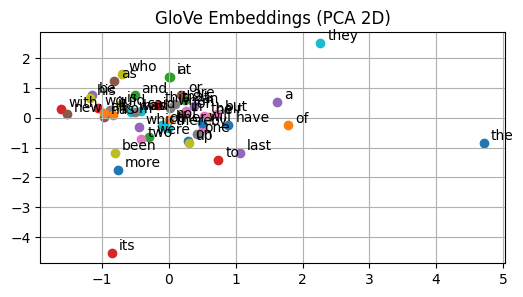

In [22]:
# Extract GloVe word embeddings (average center & outside vectors) and visualize with PCA
def get_glove_embed(word):
    idx = word2index.get(word, word2index["<UNK>"])
    idx_t = torch.LongTensor([idx])

    v = model_3.center_embedding(idx_t)
    u = model_3.outside_embedding(idx_t)
    e = (v + u) / 2.0
    return e[0].detach().cpu().numpy()

words_to_plot = vocabs[:50] 
embs = np.array([get_glove_embed(w) for w in words_to_plot])

pca = PCA(n_components=2)
embs_2d = pca.fit_transform(embs)

print("PCA variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,3))
for i, w in enumerate(words_to_plot):
    x, y = embs_2d[i]
    plt.scatter(x, y)
    plt.annotate(w, (x, y), textcoords="offset points", xytext=(5,2))

plt.title("GloVe Embeddings (PCA 2D)")
plt.grid(True)
plt.show()

### Save embeddings

In [23]:
def export_embeddings_skipgram(model):
    Wc = model.embedding_center.weight.detach().cpu().numpy()
    Wo = model.embedding_outside.weight.detach().cpu().numpy()
    return (Wc + Wo) / 2.0

def export_embeddings_glove(model):
    Wc = model.center_embedding.weight.detach().cpu().numpy()
    Wo = model.outside_embedding.weight.detach().cpu().numpy()
    return (Wc + Wo) / 2.0

# Save Skipgram Softmax
emb = export_embeddings_skipgram(model_1)

save_path = os.path.join(".", "models", f"skipgram_softmax_w{final_ws}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,emb=emb,
    vocabs=np.array(vocabs, dtype=object),
    model="skipgram_softmax",
    window_size=final_ws,
    emb_dim=emb_size,
    lr=lr,
    num_steps=num_steps,
    train_time=train_time_1)

print("Saved to:", save_path)

# Save Skipgram NEG
emb = export_embeddings_skipgram(model_2)

save_path = os.path.join(".", "models", f"skipgram_neg_w{final_ws}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,emb=emb,
    vocabs=np.array(vocabs, dtype=object),
    model="skipgram_neg",
    window_size=final_ws,
    emb_dim=emb_size,
    lr=lr,
    num_steps=num_steps,
    train_time=train_time_2,
    neg_k=K)

print("Saved to:", save_path)

# Save GloVe Scratch
emb = export_embeddings_glove(model_3)

save_path = os.path.join(".", "models", f"glove_scratch_w{final_ws}.npz")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.savez(save_path,emb=emb,
    vocabs=np.array(vocabs, dtype=object),
    model="glove",
    window_size=final_ws,
    emb_dim=embedding_size,
    lr=lr,
    num_steps=num_steps,
    train_time=train_time_3)

print("Saved to:", save_path)

Saved to: .\models\skipgram_softmax_w4.npz
Saved to: .\models\skipgram_neg_w4.npz
Saved to: .\models\glove_scratch_w4.npz
